Dataset: https://drive.google.com/drive/folders/1v2byG9D1AcgL5x5YpAGPKU4naKfCTJJs?usp=sharing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#PIA
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, GlobalAveragePooling1D, Bidirectional
from keras.models import load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

STOPWORDS = set(stopwords.words('spanish'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Funciones de preproceso

In [ ]:
# Función para quitar guiones bajos y acentos
def replace_characters(texts):
  texts = texts.replace(r"_", " ", regex=True)
  texts = texts.replace(r"á", "a", regex=True)
  texts = texts.replace(r"é", "e", regex=True)
  texts = texts.replace(r"í", "i", regex=True)
  texts = texts.replace(r"ó", "o", regex=True)
  texts = texts.replace(r"ú", "u", regex=True)
  return texts

In [ ]:
# Función para eliminar las Stopwords
def replace_stopwords(test_sentences, stopword = STOPWORDS):
  replaced_sentences = []
  for row in test_sentences:
      article = row
      for word in stopword:
          token = ' ' + word + ' '
          article = article.replace(token, ' ')
      replaced_sentences.append(article)
  return replaced_sentences

In [ ]:
# Obtener las palabras repetidas en los 5 paises

#Tokenizer unico para cada pais usando en get_stopwords_paises
def tokenizer_word_index(country_texts):
  max_features = 1000
  tokenizer = Tokenizer(num_words=max_features, split=' ', oov_token = "<OOV>")
  tokenizer.fit_on_texts(country_texts)
  word_index = tokenizer.word_index
  return word_index

def get_stopwords_paises(dataframe):
  country_list = dataframe["country"].unique()
  list_tokenizer = {}
  for country in country_list:
    tok = tokenizer_word_index(dataframe[dataframe["country"] == country]["text_new"].values)
    list_tokenizer[country] = tok

  contWord = {}
  for country in list_tokenizer:
    for i in list_tokenizer[country]:
      try:
        contWord[i] = contWord[i] + 1
      except:
        contWord[i] = 1

  new_stopword = []
  for word in contWord:
    if contWord[word] == 4:
      new_stopword.append(word)
  
  return new_stopword

In [ ]:
#Función para graficar
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

## Preproceso

### Transformación XML a CSV

In [ ]:
data_folder = 'train'

# Proceso para guardar todos los datos de cada pais en un archivo CSV

for sub_dir in os.listdir(data_folder):
  xml_file = os.listdir(os.path.join(data_folder,sub_dir))
  print(sub_dir)
  file_name = sub_dir + '.csv'
  field_names = ['text']    
  file_csv = open(file_name, "w")
  file_csv.write('text\n')
  for x_file in xml_file:
    print(x_file)
    f = open(os.path.join(data_folder,sub_dir,x_file), "r")
    n=0
    while(True):
      n += 1
      linea = f.readline()
      # linea = linea.replace("\n", "")
      if not linea:
        break
      file_csv.write(linea)
  f.close()

### Preparacion de datos de Train (Ya no se corre)

In [ ]:
# Colocamos todos los datos en un solo archivo con su respectivo pais

# Leemos los csv
argentina = pd.read_csv("/content/drive/MyDrive/ar.csv")
chile = pd.read_csv("/content/drive/MyDrive/cl.csv")
españa = pd.read_csv("/content/drive/MyDrive/es.csv")
mexico = pd.read_csv("/content/drive/MyDrive/mx.csv")
peru = pd.read_csv("/content/drive/MyDrive/pe.csv")

# Agregamos su pais
argentina["country"] = "ar"
chile["country"] = "cl"
españa["country"] = "es"
mexico["country"] = "mx"
peru["country"] = "pe"

# Los guardamos en un solo dataframe
all_texts = argentina
all_texts = all_texts.append(chile, ignore_index = True)
all_texts = all_texts.append(españa, ignore_index = True)
all_texts = all_texts.append(mexico, ignore_index = True)
all_texts = all_texts.append(peru, ignore_index = True)

# Los guardamos en un archivo csv 
all_texts.to_csv("/content/drive/MyDrive/all_texts.csv",index=False)

In [ ]:
# Carga de los datos
all_texts = pd.read_csv("/content/drive/MyDrive/all_texts.csv")

In [ ]:
# Preproceso de los datos
all_texts["text"] = replace_characters(all_texts["text"])
all_texts["text_new"] = replace_stopwords(all_texts["text"])
new_stopword = get_stopwords_paises(all_texts)
all_texts["text_Train"] = replace_stopwords(all_texts["text_new"], new_stopword)

In [ ]:
# Guardamos los datos procesados en un archivo csv
all_texts.to_csv("/content/drive/MyDrive/Texts_Train.csv",index=False)

### Preparacion de datos de Test (Ya no se corre)

In [ ]:
# Colocamos todos los datos en un solo archivo con su respectivo pais

# Leemos los csv
argentina_test = pd.read_csv("/content/drive/MyDrive/ar_test.csv")
chile_test = pd.read_csv("/content/drive/MyDrive/cl_test.csv")
españa_test = pd.read_csv("/content/drive/MyDrive/es_test.csv")
mexico_test = pd.read_csv("/content/drive/MyDrive/mx_test.csv")
peru_test = pd.read_csv("/content/drive/MyDrive/pe_test.csv")

# Agregamos su pais
argentina_test["country"] = "ar"
chile_test["country"] = "cl"
españa_test["country"] = "es"
mexico_test["country"] = "mx"
peru_test["country"] = "pe"

# Los guardamos en un solo dataframe
all_texts_test = argentina_test
all_texts_test = all_texts_test.append(chile_test, ignore_index = True)
all_texts_test = all_texts_test.append(españa_test, ignore_index = True)
all_texts_test = all_texts_test.append(mexico_test, ignore_index = True)
all_texts_test = all_texts_test.append(peru_test, ignore_index = True)

# Los guardamos en un archivo csv 
all_texts_test.to_csv("/content/drive/MyDrive/all_texts_test.csv",index=False)

In [ ]:
# Carga de los datos
all_texts_test = pd.read_csv("/content/drive/MyDrive/all_texts_test.csv")

In [ ]:
# Preproceso de los datos
all_texts_test["text"] = replace_characters(all_texts_test["text"])
all_texts_test["text_new"] = replace_stopwords(all_texts_test["text"])
new_stopword = get_stopwords_paises(all_texts_test)
all_texts_test["text_Test"] = replace_stopwords(all_texts_test["text_new"], new_stopword)

In [ ]:
# Guardamos los datos procesados en un archivo csv
all_texts_test.to_csv("/content/drive/MyDrive/Texts_Test.csv",index=False)

## Tokenizing

In [ ]:
# Carga de los datos
all_texts = pd.read_csv("/content/drive/MyDrive/all_texts.csv")

In [ ]:
# Preparamos el Tokenaizer con el archivo all_texts.csv para tener el mayor numero de palabras posible
max_features = 10000
tokenizer = Tokenizer(num_words=max_features, split=' ', oov_token = "<OOV>")
tokenizer.fit_on_texts(all_texts["text_new"].values)
word_index = tokenizer.word_index

## Proceso

### Split Train and Test

In [ ]:
# Carga de los datos
all_texts = pd.read_csv("/content/drive/MyDrive/Texts_Train.csv")
all_texts

,text,country,text_new,text_Train
0,brother where art thou significo otro exito ba...,ar,brother where art thou significo exito basado ...,brother where art thou significo exito basado ...
1,carta kretina los furiosos fanaticos defensore...,ar,carta kretina furiosos fanaticos defensores mo...,carta kretina fanaticos defensores modelo cuba...
2,disculpen por esta reflexion discriminativa de...,ar,disculpen reflexion discriminativa genero creo...,disculpen reflexion discriminativa genero creo...
3,absorbentes sanitarios para gatos la diatomita...,ar,absorbentes sanitarios gatos diatomita tierra ...,absorbentes sanitarios gatos diatomita tierra ...
4,cuando una pareja decide terminar su vinculaci...,ar,cuando pareja decide terminar vinculacion vien...,cuando pareja decide terminar vinculacion vien...
...,...,...,...,...
22918,es que si en algun momento nos parecio haber v...,pe,es si algun momento parecio haber visto eva me...,es si algun momento parecio haber visto eva me...
22919,hola todos despues de ya muchos meses retomo l...,pe,hola despues meses retomo riendas blog siempre...,hola despues meses retomo riendas blog siempre...
22920,para quienes quienes quieren conocer mas de se...,pe,para quienes quieren conocer mas selena gomez ...,para quienes quieren conocer mas gomez nombre ...
22921,un dibujito que llama la atencion porque no pu...,pe,un dibujito llama atencion puedes evitar reirt...,un dibujito llama atencion puedes evitar reirt...


In [ ]:
# Split Train and Test
X_train, X_val, y_train, y_val = train_test_split(all_texts["text_Train"], all_texts["country"], test_size=0.20, random_state=42)

# Transformamos el texto a secuencia de datos numericos
X_train_sequences = tokenizer.texts_to_sequences(X_train.values)

# Agregamos un Padding para que obtengan el mismo tamaño
X_train_padded = pad_sequences(X_train_sequences, padding='post', truncating='post', maxlen=60)

# Transformamos el texto a secuencia de datos numericos
X_val_sequences = tokenizer.texts_to_sequences(X_val.values)

# Agregamos un Padding para que obtengan el mismo tamaño
X_val_padded = pad_sequences(X_val_sequences, padding='post', truncating='post', maxlen=60)

# Categorical values for labels
y_train = pd.get_dummies(y_train).values
y_val = pd.get_dummies(y_val).values

### MODEL

In [ ]:
# Creamos el modelo
embedding_dim = 64
model = Sequential()
model.add(Embedding(max_features, embedding_dim, input_length=X_train_padded.shape[1]),)
model.add(Bidirectional(LSTM(50)))
model.add(Dense(5, activation='softmax'))

# Compilamos el modelo
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 60, 64)            640000    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 100)               46000     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 505       
Total params: 686,505
Trainable params: 686,505
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Model Training
num_epochs = 5
history = model.fit(X_train_padded, y_train, validation_data=(X_val_padded, y_val), epochs=num_epochs, batch_size=32, verbose=2)

Epoch 1/5
574/574 - 12s - loss: 0.4862 - accuracy: 0.3006 - val_loss: 0.4691 - val_accuracy: 0.3832
Epoch 2/5
574/574 - 9s - loss: 0.3858 - accuracy: 0.5354 - val_loss: 0.3780 - val_accuracy: 0.5518
Epoch 3/5
574/574 - 8s - loss: 0.2676 - accuracy: 0.7175 - val_loss: 0.3959 - val_accuracy: 0.5592
Epoch 4/5
574/574 - 8s - loss: 0.1941 - accuracy: 0.8104 - val_loss: 0.4260 - val_accuracy: 0.5544
Epoch 5/5
574/574 - 8s - loss: 0.1381 - accuracy: 0.8760 - val_loss: 0.4825 - val_accuracy: 0.5477


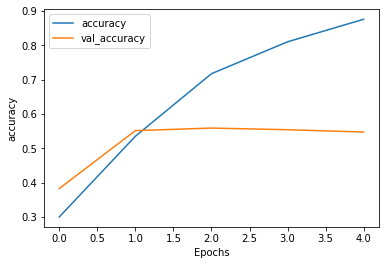

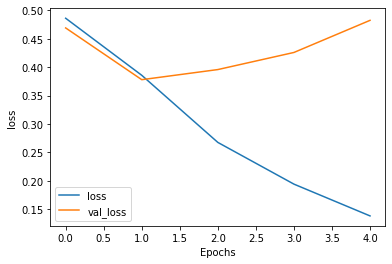

In [ ]:
# Graficamos
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Predict

In [ ]:
# Carga de los datos
all_texts_test = pd.read_csv("/content/drive/MyDrive/Texts_Test.csv")
all_texts_test

,text,country,text_new,text_Test
0,la dgcye informo que el de noviembre abonara l...,ar,la dgcye informo noviembre abonara haberes doc...,la dgcye informo noviembre abonara haberes doc...
1,por medio del presente se informa que el dia d...,ar,por medio presente informa dia noviembre corri...,por medio presente informa dia noviembre corri...
2,lunes asambleas acciones distritales convocada...,ar,lunes asambleas acciones distritales convocada...,lunes acciones distritales convocadas udocba m...
3,mediante la resolucion se establecen las pauta...,ar,mediante resolucion establecen pautas renovaci...,mediante resolucion establecen pautas renovaci...
4,accede al material de trabajo para la jornada ...,ar,accede material trabajo jornada noviembre haci...,accede material trabajo jornada noviembre haci...
...,...,...,...,...
9173,el ha sido un año intenso para la cinematograf...,pe,el sido año intenso cinematografia peruana mas...,el sido año intenso cinematografia peruana mas...
9174,el ministerio de cultura ha dado conocer los r...,pe,el ministerio cultura dado conocer resultados ...,el ministerio cultura dado conocer resultados ...
9175,el ministerio de cultura ha dado conocer el re...,pe,el ministerio cultura dado conocer resultado c...,el ministerio cultura dado conocer resultado c...
9176,la encuesta que todos los años realizamos en e...,pe,la encuesta años realizamos blog llego fin ama...,la encuesta años realizamos blog llego fin lec...


In [ ]:
model = load_model('/content/drive/MyDrive/bidirectional_model.h5')

In [ ]:
# Transformamos el texto a secuencia de datos numericos
X_test_sequences = tokenizer.texts_to_sequences(all_texts_test["text"].values)

# Agregamos un Padding para que obtengan el mismo tamaño
X_test_padded = pad_sequences(X_test_sequences, padding='post', truncating='post', maxlen=60)

# Hacemos las predicciones del modelo para probarlo
predictions = model.predict(X_test_padded)

# Obtenemos el indice del valor mas alto (mas cercano a 1)
all_texts_test["predictions"] = [np.argmax(x) for x in predictions]

# Iniciamos un diccionario donde la llave representa el pais al que hace referencia el indice guardado preciamente
countries = {
    "ar":0,
    "cl":1,
    "es":2,
    "mx":3,
    "pe":4
}

# Colocamos la predicción a cada texto
all_texts_test["country_label"] = [countries[x] for x in all_texts_test["country"]]
all_texts_test

,text,country,text_new,text_Test,predictions,country_label
0,la dgcye informo que el de noviembre abonara l...,ar,la dgcye informo noviembre abonara haberes doc...,la dgcye informo noviembre abonara haberes doc...,3,0
1,por medio del presente se informa que el dia d...,ar,por medio presente informa dia noviembre corri...,por medio presente informa dia noviembre corri...,3,0
2,lunes asambleas acciones distritales convocada...,ar,lunes asambleas acciones distritales convocada...,lunes acciones distritales convocadas udocba m...,0,0
3,mediante la resolucion se establecen las pauta...,ar,mediante resolucion establecen pautas renovaci...,mediante resolucion establecen pautas renovaci...,1,0
4,accede al material de trabajo para la jornada ...,ar,accede material trabajo jornada noviembre haci...,accede material trabajo jornada noviembre haci...,0,0
...,...,...,...,...,...,...
9173,el ha sido un año intenso para la cinematograf...,pe,el sido año intenso cinematografia peruana mas...,el sido año intenso cinematografia peruana mas...,4,4
9174,el ministerio de cultura ha dado conocer los r...,pe,el ministerio cultura dado conocer resultados ...,el ministerio cultura dado conocer resultados ...,4,4
9175,el ministerio de cultura ha dado conocer el re...,pe,el ministerio cultura dado conocer resultado c...,el ministerio cultura dado conocer resultado c...,4,4
9176,la encuesta que todos los años realizamos en e...,pe,la encuesta años realizamos blog llego fin ama...,la encuesta años realizamos blog llego fin lec...,4,4


In [ ]:
# Obtenemos el acuraccy
from sklearn.metrics import accuracy_score
accuracy_score(all_texts_test["country_label"], all_texts_test["predictions"])

0.39529309217694486

In [ ]:
# Obtenemos la confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf_matrix = confusion_matrix(all_texts_test["country_label"],all_texts_test["predictions"])
cf_matrix

array([[850, 439, 287, 218,  99],
       [335, 886, 186, 174,  70],
       [425, 379, 753, 257,  75],
       [443, 408, 287, 662, 111],
       [444, 434, 205, 274, 477]])

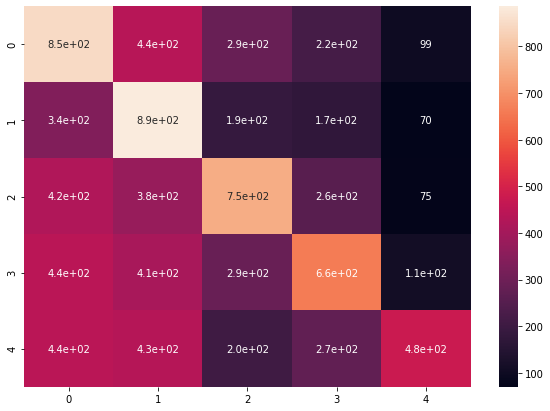

In [ ]:
# Graficamos la confusion matrix
# Entre mas claro mejor
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
df_cm = pd.DataFrame(cf_matrix, index = [i for i in "01234"],
                  columns = [i for i in "01234"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [ ]:
# Guardar el Modelo
model.save('/content/drive/MyDrive/PIA IAP/bidirectional_model.h5')